In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.experimental import enable_iterative_imputer
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Load datasets
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')
sample_submission = pd.read_csv('dataset/sample_submission.csv')

In [16]:
# Basic information
print("Training Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nTraining Data Info:")
print(train_df.info())
print("\nFirst few rows:")
train_df.head()

Training Data Shape: (20000, 17)
Test Data Shape: (12000, 16)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   temperature         18999 non-null  float64
 2   irradiance          19013 non-null  float64
 3   humidity            20000 non-null  object 
 4   panel_age           18989 non-null  float64
 5   maintenance_count   18973 non-null  float64
 6   soiling_ratio       18990 non-null  float64
 7   voltage             19007 non-null  float64
 8   current             19023 non-null  float64
 9   module_temperature  19022 non-null  float64
 10  cloud_coverage      18990 non-null  float64
 11  wind_speed          20000 non-null  object 
 12  pressure            20000 non-null  object 
 13  string_id           20000 non-null  object 
 14  error_code         

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
0,0,7.817315,576.179270,41.24308670850264,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.82491203459621,1018.8665053152533,A1,NaN,NaN,0.562096
1,1,24.785727,240.003973,1.3596482765960705,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012043660984917,1025.6238537572883,D4,E00,dual-axis,0.396447
2,2,46.652695,687.612799,91.26536837560256,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,NaN,1.814399755560454,1010.9226539809573,C3,E00,NaN,0.573776
3,3,53.339567,735.141179,96.19095521176159,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,67.361473,8.736258932034128,1021.8466633134253,A1,NaN,dual-axis,0.629009
4,4,5.575374,12.241203,27.495073003585226,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.52268384077164,1008.5559577591927,B2,E00,fixed,0.341874


Target Variable Analysis

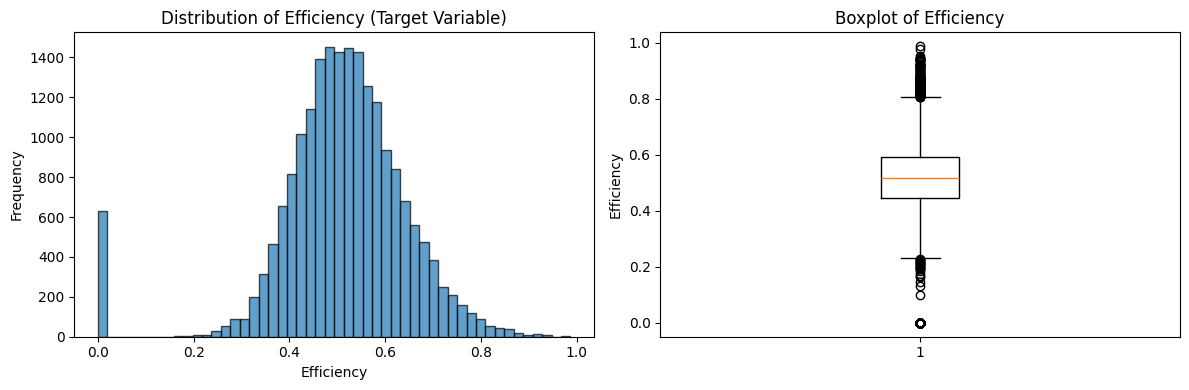

Efficiency Statistics:
count    20000.000000
mean         0.510260
std          0.140420
min          0.000000
25%          0.445613
50%          0.515709
75%          0.590324
max          0.987066
Name: efficiency, dtype: float64
Skewness: -1.156
Kurtosis: 3.730


In [17]:
# Target variable distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(train_df['efficiency'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Efficiency (Target Variable)')
plt.xlabel('Efficiency')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(train_df['efficiency'])
plt.title('Boxplot of Efficiency')
plt.ylabel('Efficiency')
plt.tight_layout()
plt.show()

# Statistical summary
print("Efficiency Statistics:")
print(train_df['efficiency'].describe())
print(f"Skewness: {stats.skew(train_df['efficiency']):.3f}")
print(f"Kurtosis: {stats.kurtosis(train_df['efficiency']):.3f}")

Missing Values Analysis


Training Data - Missing Values Summary:
                Column  Missing_Count  Missing_Percentage
14          error_code           5912              29.560
15   installation_type           5028              25.140
5    maintenance_count           1027               5.135
4            panel_age           1011               5.055
6        soiling_ratio           1010               5.050
10      cloud_coverage           1010               5.050
1          temperature           1001               5.005
7              voltage            993               4.965
2           irradiance            987               4.935
9   module_temperature            978               4.890
8              current            977               4.885


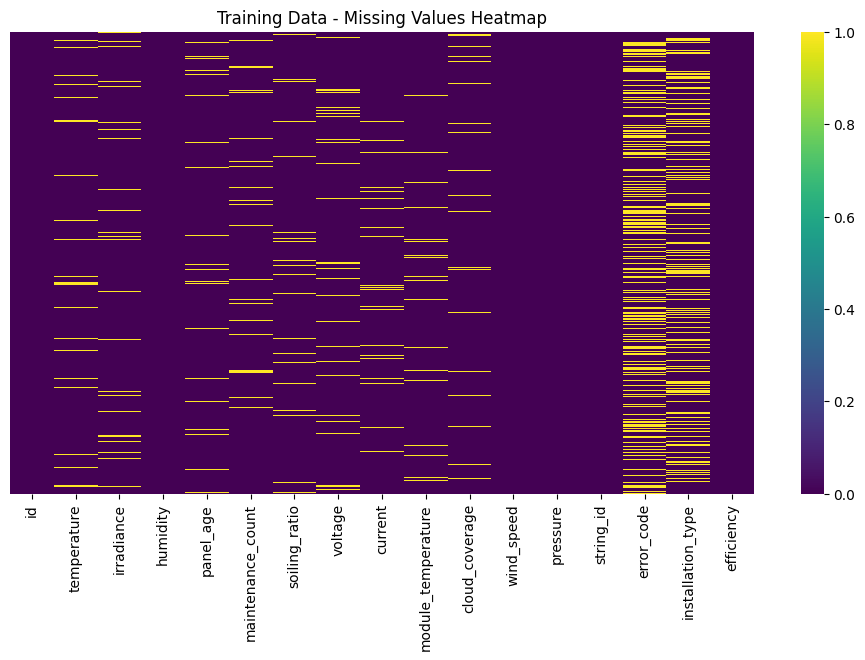


Test Data - Missing Values Summary:
                Column  Missing_Count  Missing_Percentage
14          error_code           3611           30.091667
15   installation_type           2979           24.825000
2           irradiance            615            5.125000
6        soiling_ratio            610            5.083333
5    maintenance_count            609            5.075000
4            panel_age            607            5.058333
8              current            587            4.891667
1          temperature            582            4.850000
10      cloud_coverage            582            4.850000
9   module_temperature            580            4.833333
7              voltage            547            4.558333


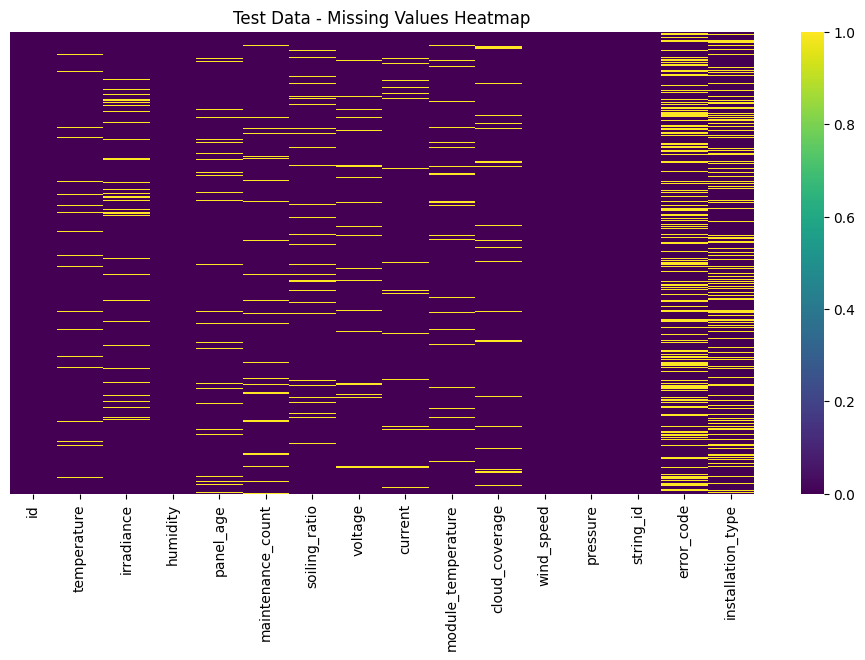

In [18]:
def analyze_missing_values(df, dataset_name):
    """Comprehensive missing value analysis"""
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_df = pd.DataFrame({
        'Column': missing_data.index,
        'Missing_Count': missing_data.values,
        'Missing_Percentage': missing_percent.values
    }).sort_values('Missing_Percentage', ascending=False)
    
    print(f"\n{dataset_name} - Missing Values Summary:")
    print(missing_df[missing_df['Missing_Count'] > 0])
    
    # Visual representation
    if missing_df['Missing_Count'].sum() > 0:
        plt.figure(figsize=(12, 6))
        sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
        plt.title(f'{dataset_name} - Missing Values Heatmap')
        plt.show()
    
    return missing_df

# Analyze missing values in both datasets
train_missing = analyze_missing_values(train_df, "Training Data")
test_missing = analyze_missing_values(test_df, "Test Data")

Data Types and Inconsistencies

1. humidity (object)
2. wind speead (object)
3. pressure (object)

In [19]:
def analyze_data_types(df):
    """Analyze data types and identify inconsistencies"""
    print("Data Types:")
    print(df.dtypes)
    
    # Check for mixed data types in supposedly numeric columns
    numeric_cols = ['temperature', 'irradiance', 'humidity', 'panel_age', 
                   'maintenance_count', 'soiling_ratio', 'voltage', 'current',
                   'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure']
    
    for col in numeric_cols:
        if col in df.columns:
            # Check if column has non-numeric values
            try:
                pd.to_numeric(df[col], errors='raise')
            except:
                print(f"\n{col} contains non-numeric values:")
                non_numeric = df[~pd.to_numeric(df[col], errors='coerce').notna()]
                print(non_numeric[col].value_counts())

analyze_data_types(train_df)

Data Types:
id                      int64
temperature           float64
irradiance            float64
humidity               object
panel_age             float64
maintenance_count     float64
soiling_ratio         float64
voltage               float64
current               float64
module_temperature    float64
cloud_coverage        float64
wind_speed             object
pressure               object
string_id              object
error_code             object
installation_type      object
efficiency            float64
dtype: object

humidity contains non-numeric values:
humidity
unknown    50
error      40
badval     37
Name: count, dtype: int64

wind_speed contains non-numeric values:
wind_speed
badval     42
error      41
unknown    36
Name: count, dtype: int64

pressure contains non-numeric values:
pressure
unknown    46
error      45
badval     44
Name: count, dtype: int64


In [ ]:
def fix_data_types(df, dataset_name):
    """Fix data type inconsistencies for specific columns"""
    df_fixed = df.copy()
    
    # Define columns that should be numeric
    numeric_columns_to_fix = ['humidity', 'wind_speed', 'pressure']
    
    print(f"\n=== FIXING DATA TYPES FOR {dataset_name} ===")
    
    for col in numeric_columns_to_fix:
        if col in df_fixed.columns:
            print(f"\nProcessing {col}:")
            print(f"Original dtype: {df_fixed[col].dtype}")
            
            # Check for non-numeric values before conversion
            if df_fixed[col].dtype == 'object':
                # Display unique non-numeric values
                try:
                    # Try to convert to numeric and see what fails
                    numeric_conversion = pd.to_numeric(df_fixed[col], errors='coerce')
                    non_numeric_mask = pd.isna(numeric_conversion) & df_fixed[col].notna()
                    
                    if non_numeric_mask.any():
                        print(f"Non-numeric values found in {col}:")
                        non_numeric_values = df_fixed.loc[non_numeric_mask, col].value_counts()
                        print(non_numeric_values.head(10))
                        
                        # Handle common non-numeric patterns
                        df_fixed[col] = df_fixed[col].astype(str)
                        
                        # Remove common problematic characters
                        df_fixed[col] = df_fixed[col].str.replace(r'[^\d.-]', '', regex=True)
                        df_fixed[col] = df_fixed[col].str.strip()
                        
                        # Handle empty strings
                        df_fixed[col] = df_fixed[col].replace('', np.nan)
                        df_fixed[col] = df_fixed[col].replace('nan', np.nan)
                        
                    
                    # Convert to numeric
                    df_fixed[col] = pd.to_numeric(df_fixed[col], errors='coerce')
                    
                    print(f"Converted dtype: {df_fixed[col].dtype}")
                    print(f"Missing values after conversion: {df_fixed[col].isnull().sum()}")
                    print(f"Valid numeric values: {df_fixed[col].notna().sum()}")
                    
                    # Basic statistics for converted column
                    if df_fixed[col].notna().any():
                        print(f"Min: {df_fixed[col].min():.3f}")
                        print(f"Max: {df_fixed[col].max():.3f}")
                        print(f"Mean: {df_fixed[col].mean():.3f}")
                    
                except Exception as e:
                    print(f"Error converting {col}: {str(e)}")
            else:
                print(f"{col} is already numeric type: {df_fixed[col].dtype}")
    
    return df_fixed

# Apply data type fixes to both datasets
print("Fixing data types before proceeding with analysis...")
train_df_fixed = fix_data_types(train_df, "TRAINING DATA")
test_df_fixed = fix_data_types(test_df, "TEST DATA")

# Verify the fixes
print("\n=== DATA TYPE VERIFICATION ===")
print("Training data types after fixing:")
for col in ['humidity', 'wind_speed', 'pressure']:
    if col in train_df_fixed.columns:
        print(f"{col}: {train_df_fixed[col].dtype}")

print("\nTest data types after fixing:")
for col in ['humidity', 'wind_speed', 'pressure']:
    if col in test_df_fixed.columns:
        print(f"{col}: {test_df_fixed[col].dtype}")

Fixing data types before proceeding with analysis...

=== FIXING DATA TYPES FOR TRAINING DATA ===

Processing humidity:
Original dtype: object
Non-numeric values found in humidity:
humidity
unknown    50
error      40
badval     37
Name: count, dtype: int64
Converted dtype: float64
Missing values after conversion: 127
Valid numeric values: 19873
Min: 0.011
Max: 99.995
Mean: 50.066

Processing wind_speed:
Original dtype: object
Non-numeric values found in wind_speed:
wind_speed
badval     42
error      41
unknown    36
Name: count, dtype: int64
Converted dtype: float64
Missing values after conversion: 119
Valid numeric values: 19881
Min: 0.001
Max: 14.999
Mean: 7.413

Processing pressure:
Original dtype: object
Non-numeric values found in pressure:
pressure
unknown    46
error      45
badval     44
Name: count, dtype: int64
Converted dtype: float64
Missing values after conversion: 135
Valid numeric values: 19865
Min: 970.087
Max: 1052.866
Mean: 1012.981

=== FIXING DATA TYPES FOR TEST D

In [24]:
train_df = train_df_fixed
test_df = test_df_fixed

Categorical Variables Analysis

In [29]:
def analyze_categorical_variables(df):
    """Analyze categorical variables for inconsistencies"""
    categorical_cols = ['string_id', 'error_code', 'installation_type']
    
    for col in categorical_cols:
        if col in df.columns:
            print(f"\n{col} - Unique Values:")
            print(f"Count: {df[col].nunique()}")
            print("Values:", df[col].value_counts().head(10))
            
            # Check for inconsistent formatting
            if df[col].dtype == 'object':
                # Check for leading/trailing spaces
                has_spaces = df[col].astype(str).str.strip() != df[col].astype(str)
                if has_spaces.any():
                    print(f"Warning: {col} has leading/trailing spaces")
                
                # Check for case inconsistencies
                unique_lower = df[col].astype(str).str.lower().nunique()
                unique_original = df[col].nunique()
                if unique_lower < unique_original:
                    print(f"Warning: {col} may have case inconsistencies")

analyze_categorical_variables(train_df_fixed)


string_id - Unique Values:
Count: 4
Values: string_id
D4    5080
B2    5014
C3    5004
A1    4902
Name: count, dtype: int64

error_code - Unique Values:
Count: 3
Values: error_code
E00    5977
E01    4100
E02    4011
Name: count, dtype: int64

installation_type - Unique Values:
Count: 3
Values: installation_type
tracking     5067
fixed        4990
dual-axis    4915
Name: count, dtype: int64


## Advanced Data Cleaning

Outlier Detection and Treatment

In [32]:
def detect_outliers_iqr(df, column):
    """Detect outliers using IQR method"""
    # Handle missing values
    valid_data = df[column].dropna()
    
    if len(valid_data) == 0:
        return df.iloc[0:0], np.nan, np.nan  # Return empty dataframe and NaN bounds
    
    Q1 = valid_data.quantile(0.25)
    Q3 = valid_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Find outliers using the bounds
    outlier_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    outliers = df[outlier_mask & df[column].notna()]  # Only consider non-null values
    
    return outliers, lower_bound, upper_bound

def detect_outliers_zscore(df, column, threshold=3):
    """Detect outliers using Z-score method"""
    # Create a copy to avoid modifying original data
    valid_data = df[column].dropna()
    
    if len(valid_data) == 0:
        return df.iloc[0:0]  # Return empty dataframe with same structure
    
    # Calculate z-scores only for non-null values
    z_scores = np.abs(stats.zscore(valid_data))
    
    # Get indices of outliers from the valid data
    outlier_indices = valid_data.index[z_scores > threshold]
    
    # Return rows corresponding to outlier indices
    outliers = df.loc[outlier_indices]
    return outliers

# Analyze outliers for numeric columns (using fixed data)
numeric_columns = train_df_fixed.select_dtypes(include=[np.number]).columns
outlier_summary = {}

for col in numeric_columns:
    if col != 'id':  # Skip ID column
        outliers_iqr, lower, upper = detect_outliers_iqr(train_df_fixed, col)
        outliers_zscore = detect_outliers_zscore(train_df_fixed, col)
        
        outlier_summary[col] = {
            'IQR_outliers': len(outliers_iqr),
            'IQR_percentage': len(outliers_iqr) / len(train_df_fixed) * 100,
            'Z_score_outliers': len(outliers_zscore),
            'Z_score_percentage': len(outliers_zscore) / len(train_df_fixed) * 100,
            'lower_bound': lower,
            'upper_bound': upper
        }

outlier_df = pd.DataFrame(outlier_summary).T
print("Outlier Analysis Summary:")
outlier_df

Outlier Analysis Summary:


,IQR_outliers,IQR_percentage,Z_score_outliers,Z_score_percentage,lower_bound,upper_bound
temperature,104.0,0.520,34.0,0.170,-7.139571,56.842010
irradiance,136.0,0.680,55.0,0.275,-172.056910,1172.700921
humidity,0.0,0.000,0.0,0.000,-48.587055,148.374624
panel_age,0.0,0.000,0.0,0.000,-17.566380,52.685046
maintenance_count,424.0,2.120,55.0,0.275,0.000000,8.000000
soiling_ratio,0.0,0.000,0.0,0.000,0.104877,1.293615
voltage,116.0,0.580,75.0,0.375,-39.835983,66.393306
current,132.0,0.660,86.0,0.430,-1.781340,5.028394
module_temperature,66.0,0.330,0.0,0.000,-3.337103,62.954171
cloud_coverage,32.0,0.160,32.0,0.160,-49.875191,150.009633


In [34]:
train_df_fixed.describe()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,efficiency
count,20000.000000,18999.000000,19013.000000,19873.000000,18989.000000,18973.000000,18990.000000,19007.000000,19023.000000,19022.000000,18990.000000,19881.000000,19865.000000,20000.000000
mean,9999.500000,25.077241,501.273896,50.066170,17.509758,4.012070,0.698879,16.242251,1.713396,29.923807,51.378575,7.413225,1012.981286,0.510260
std,5773.647028,12.513129,250.926590,28.709656,10.097557,2.002268,0.172244,17.889031,1.152953,12.125405,48.473664,4.329861,10.046245,0.140420
min,0.000000,0.000000,-597.278646,0.010714,0.001264,0.000000,0.400149,0.000000,0.000054,0.000000,0.000244,0.001277,970.087365,0.000000
25%,4999.750000,16.853522,332.227277,25.273574,8.777905,3.000000,0.550654,0.000000,0.772311,21.522124,25.081618,3.668529,1006.187799,0.445613
50%,9999.500000,24.720345,499.654730,50.224152,17.497731,4.000000,0.697663,12.350138,1.558413,29.857669,49.704133,7.396091,1012.906121,0.515709
75%,14999.250000,32.848917,668.416734,74.513994,26.340761,5.000000,0.847838,26.557322,2.474744,38.094943,75.052824,11.158582,1019.786203,0.590324
max,19999.000000,147.394168,1537.810349,99.995202,34.998379,15.000000,0.999949,494.279016,7.315597,65.000000,1000.000000,14.999448,1052.865715,0.987066


Domain-Specific Data Validation

In [35]:
def validate_solar_data(df):
    """Validate data based on solar panel domain knowledge"""
    issues = []
    
    # Temperature checks (reasonable range: -40°C to 70°C)
    if 'temperature' in df.columns:
        temp_issues = df[(df['temperature'] < -40) | (df['temperature'] > 70)]
        if len(temp_issues) > 0:
            issues.append(f"Temperature out of range: {len(temp_issues)} records")
    
    # Irradiance checks (0 to 1400 W/m²)
    if 'irradiance' in df.columns:
        irr_issues = df[(df['irradiance'] < 0) | (df['irradiance'] > 1400)]
        if len(irr_issues) > 0:
            issues.append(f"Irradiance out of range: {len(irr_issues)} records")
    
    # Humidity checks (0 to 100%)
    if 'humidity' in df.columns:
        hum_issues = df[(df['humidity'] < 0) | (df['humidity'] > 100)]
        if len(hum_issues) > 0:
            issues.append(f"Humidity out of range: {len(hum_issues)} records")
    
    # Soiling ratio checks (0.0 to 1.0)
    if 'soiling_ratio' in df.columns:
        soil_issues = df[(df['soiling_ratio'] < 0) | (df['soiling_ratio'] > 1)]
        if len(soil_issues) > 0:
            issues.append(f"Soiling ratio out of range: {len(soil_issues)} records")
    
    # Cloud coverage checks (0 to 100%)
    if 'cloud_coverage' in df.columns:
        cloud_issues = df[(df['cloud_coverage'] < 0) | (df['cloud_coverage'] > 100)]
        if len(cloud_issues) > 0:
            issues.append(f"Cloud coverage out of range: {len(cloud_issues)} records")
    
    # Voltage and current should be positive
    if 'voltage' in df.columns:
        volt_issues = df[df['voltage'] < 0]
        if len(volt_issues) > 0:
            issues.append(f"Negative voltage: {len(volt_issues)} records")
    
    if 'current' in df.columns:
        curr_issues = df[df['current'] < 0]
        if len(curr_issues) > 0:
            issues.append(f"Negative current: {len(curr_issues)} records")
    
    return issues

# Validate both datasets (using fixed data)
train_issues = validate_solar_data(train_df_fixed)
test_issues = validate_solar_data(test_df_fixed)

print("Training Data Issues:")
for issue in train_issues:
    print(f"- {issue}")

print("\nTest Data Issues:")
for issue in test_issues:
    print(f"- {issue}")

Training Data Issues:
- Temperature out of range: 34 records
- Irradiance out of range: 426 records
- Cloud coverage out of range: 32 records

Test Data Issues:
- Temperature out of range: 12 records
- Irradiance out of range: 254 records
- Cloud coverage out of range: 16 records


### Oberservations

1. Temperature greater than 70 is highly unlikely and data corresponding to them is bad data and should be removed
2.      Negative        Irradiance	Not possible
        Zero            Irradiance	Possible (complete darkness)
        >1400 W/m²      Irradiance	Possible (rare, with reflection or special conditions
3. Humidity, soiling no issues
4. Cloud coverage cannot be greater than 100, impute it with mean or median or maybe adv imputation techniques.
5. Voltage/current no issues

In [56]:
# Display rows with issues so they can be inspected or dropped

def get_invalid_rows(df):
    invalid_rows = pd.DataFrame()

    if 'temperature' in df.columns:
        invalid_rows = pd.concat([invalid_rows, df[(df['temperature'] < -40) | (df['temperature'] > 70)]])
    if 'irradiance' in df.columns:
        invalid_rows = pd.concat([invalid_rows, df[(df['irradiance'] < 0) | (df['irradiance'] > 1400)]])
    if 'humidity' in df.columns:
        invalid_rows = pd.concat([invalid_rows, df[(df['humidity'] < 0) | (df['humidity'] > 100)]])
    if 'soiling_ratio' in df.columns:
        invalid_rows = pd.concat([invalid_rows, df[(df['soiling_ratio'] < 0) | (df['soiling_ratio'] > 1)]])
    if 'cloud_coverage' in df.columns:
        invalid_rows = pd.concat([invalid_rows, df[(df['cloud_coverage'] < 0) | (df['cloud_coverage'] > 100)]])
    if 'voltage' in df.columns:
        invalid_rows = pd.concat([invalid_rows, df[df['voltage'] < 0]])
    if 'current' in df.columns:
        invalid_rows = pd.concat([invalid_rows, df[df['current'] < 0]])

    # Remove duplicates if a row had multiple issues
    invalid_rows = invalid_rows.drop_duplicates()
    
    return invalid_rows

# Get invalid rows
invalid_train_rows = get_invalid_rows(train_df_fixed)
invalid_test_rows = get_invalid_rows(test_df_fixed)

print(f"Number of invalid rows in training data: {len(invalid_train_rows)}")
display(invalid_train_rows)

print(f"\nNumber of invalid rows in test data: {len(invalid_test_rows)}")
display(invalid_test_rows)

Number of invalid rows in training data: 490


,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
621,621,137.411433,508.026918,97.486816,17.446867,0.0,0.547299,44.187088,1.758452,43.480398,97.361315,8.432728,999.835981,B2,E01,fixed,0.506449
782,782,136.051106,949.390292,68.731683,8.390731,4.0,0.534720,14.550575,4.313879,42.544161,84.609502,7.592960,1020.121810,C3,E00,tracking,0.645649
1686,1686,126.745876,365.420949,86.848524,10.028666,4.0,0.636871,2.042753,NaN,29.095638,33.247734,6.672615,1014.864983,A1,E02,fixed,0.465543
2156,2156,107.149504,583.133078,8.938540,20.344794,7.0,0.892080,6.972159,3.574584,13.658967,NaN,1.326721,1011.410304,D4,E01,NaN,0.611615
3343,3343,111.990702,695.532060,79.967791,30.518622,3.0,NaN,2.785258,NaN,11.885883,82.833685,14.724349,1023.856614,A1,E02,NaN,0.612309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16348,16348,35.233306,564.783023,63.101186,18.704749,5.0,0.842064,12.254685,1.893334,43.141476,1000.000000,0.119788,1017.702331,C3,NaN,dual-axis,0.566717
17499,17499,5.653165,1103.269684,65.457748,10.989324,4.0,0.659703,62.635700,2.812169,8.411974,1000.000000,6.646923,1025.518424,B2,E01,NaN,0.772545
18825,18825,44.328000,542.460953,71.836254,15.066994,5.0,NaN,0.221682,0.397484,55.127634,1000.000000,9.711988,1019.840526,A1,E00,tracking,0.460820
18865,18865,34.074955,843.684991,50.858808,19.933412,3.0,0.639114,25.823564,1.790253,39.926045,1000.000000,4.357335,1022.121257,D4,E00,dual-axis,0.000000



Number of invalid rows in test data: 282


,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type
271,271,114.545905,268.668308,13.253172,21.214101,2.0,0.946311,14.990474,0.526404,22.847753,34.284734,5.942641,1004.495693,D4,E00,NaN
399,399,142.216284,475.047592,63.209311,33.357182,5.0,0.826903,1.583152,1.571379,51.849376,18.584538,8.634581,1007.286506,B2,NaN,dual-axis
1189,1189,128.546320,164.690252,87.395665,NaN,8.0,0.483386,7.155602,0.123168,29.173623,86.961600,6.592501,1018.303349,C3,E01,fixed
3789,3789,130.918088,618.449792,7.951486,3.591819,2.0,0.461711,22.284895,0.615904,36.543825,99.995651,8.969529,1019.081421,C3,E01,fixed
4336,4336,106.791582,377.551723,46.201358,0.813577,3.0,0.851040,22.545157,1.616226,9.051256,92.601690,7.692350,1001.341432,A1,E02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8197,8197,37.924587,704.303863,94.329870,2.339674,5.0,0.593207,22.129633,1.033783,46.771311,1000.000000,14.525498,1025.960642,A1,NaN,dual-axis
8286,8286,39.874241,169.108184,31.988709,29.136289,5.0,0.461805,6.744972,1.002340,49.973915,1000.000000,9.902134,1020.855102,D4,NaN,fixed
9090,9090,0.000000,441.214583,3.984265,0.829596,NaN,0.915740,8.905014,1.934156,7.821813,1000.000000,6.125535,1008.221270,D4,E00,tracking
9261,9261,19.878354,628.310153,3.688780,29.305115,1.0,0.929502,3.483586,2.891933,22.664182,1000.000000,NaN,1024.007019,D4,E00,tracking


In [57]:
train_df_fixed.shape, test_df_fixed.shape

((20000, 17), (12000, 16))

In [59]:
def clean_solar_data(df):
    df_cleaned = df.copy()
    initial_shape = df_cleaned.shape

    # Track indexes to drop
    drop_indices = set()

    # Rule 1: Drop temperature > 70
    if 'temperature' in df_cleaned.columns:
        bad_temp = df_cleaned[df_cleaned['temperature'] > 70]
        print(f"Dropping {len(bad_temp)} rows with temperature > 70")
        drop_indices.update(bad_temp.index)

    # Rule 2: Drop irradiance < 0
    if 'irradiance' in df_cleaned.columns:
        bad_irr = df_cleaned[df_cleaned['irradiance'] < 0]
        print(f"Dropping {len(bad_irr)} rows with irradiance < 0")
        drop_indices.update(bad_irr.index)

    # Rule 4: Impute cloud_coverage > 100
    if 'cloud_coverage' in df_cleaned.columns:
        over_100 = df_cleaned['cloud_coverage'] > 100
        count_over_100 = over_100.sum()
        if count_over_100 > 0:
            median_cloud = df_cleaned.loc[df_cleaned['cloud_coverage'] <= 100, 'cloud_coverage'].median()
            print(f"Imputing {count_over_100} rows where cloud_coverage > 100 with median = {median_cloud}")
            df_cleaned.loc[over_100, 'cloud_coverage'] = median_cloud

    # Final drop
    df_cleaned = df_cleaned.drop(index=drop_indices)

    print(f"Total rows dropped: {len(drop_indices)}")
    print(f"New shape: {df_cleaned.shape} (was {initial_shape})")

    return df_cleaned

# Apply safely to both datasets
train_df_cleaned = clean_solar_data(train_df_fixed)
test_df_cleaned = clean_solar_data(test_df_fixed)


Dropping 34 rows with temperature > 70
Dropping 424 rows with irradiance < 0
Imputing 32 rows where cloud_coverage > 100 with median = 49.60936274039607
Total rows dropped: 458
New shape: (19542, 17) (was (20000, 17))
Dropping 12 rows with temperature > 70
Dropping 253 rows with irradiance < 0
Imputing 16 rows where cloud_coverage > 100 with median = 49.714138018596714
Total rows dropped: 265
New shape: (11735, 16) (was (12000, 16))


In [65]:
train_df_cleaned.to_csv('dataset/train_cleaned.csv', index=False)
test_df_cleaned.to_csv('dataset/test_cleaned.csv', index=False)
print("Cleaned datasets saved as 'train_cleaned.csv' and 'test_cleaned.csv'.")

Cleaned datasets saved as 'train_cleaned.csv' and 'test_cleaned.csv'.


In [ ]:
def advanced_imputation_strategy(train_df, test_df):
    """Implement advanced imputation techniques based on missing pattern analysis"""
    
    # Combine train and test for consistent imputation
    combined_df = pd.concat([train_df.drop('efficiency', axis=1), test_df], 
                           ignore_index=True)
    
    # Strategy 1: Simple imputation for low missing percentage (<5%)
    low_missing_cols = []
    
    # Strategy 2: KNN imputation for moderate missing (5-20%)
    moderate_missing_cols = []
    
    # Strategy 3: Iterative imputation for high missing (>20%)
    high_missing_cols = []
    
    # Strategy 4: Drop columns with >50% missing if not recoverable
    drop_cols = []
    
    missing_analysis = combined_df.isnull().sum() / len(combined_df) * 100
    
    for col, missing_pct in missing_analysis.items():
        if missing_pct == 0:
            continue
        elif missing_pct < 5:
            low_missing_cols.append(col)
        elif missing_pct < 20:
            moderate_missing_cols.append(col)
        elif missing_pct < 50:
            high_missing_cols.append(col)
        else:
            drop_cols.append(col)
    
    print("Imputation Strategy:")
    print(f"Low missing (<5%): {low_missing_cols}")
    print(f"Moderate missing (5-20%): {moderate_missing_cols}")
    print(f"High missing (20-50%): {high_missing_cols}")
    print(f"Consider dropping (>50%): {drop_cols}")
    
    # Implement imputation
    imputed_df = combined_df.copy()
    
    # Simple imputation (median for numeric, mode for categorical)
    for col in low_missing_cols:
        if imputed_df[col].dtype in ['object', 'category']:
            imputed_df[col].fillna(imputed_df[col].mode()[0], inplace=True)
        else:
            imputed_df[col].fillna(imputed_df[col].median(), inplace=True)
    
    # KNN imputation for moderate missing
    if moderate_missing_cols:
        numeric_cols = imputed_df.select_dtypes(include=[np.number]).columns
        knn_imputer = KNNImputer(n_neighbors=5)
        
        for col in moderate_missing_cols:
            if col in numeric_cols:
                # Use correlated features for KNN imputation
                corr_matrix = imputed_df[numeric_cols].corr()
                highly_corr = corr_matrix[col].abs().sort_values(ascending=False)[1:6]
                features_for_knn = [col] + list(highly_corr.index)
                
                imputed_values = knn_imputer.fit_transform(
                    imputed_df[features_for_knn]
                )
                imputed_df[col] = imputed_values[:, 0]
    
    # Iterative imputation for high missing
    if high_missing_cols:
        numeric_high_missing = [col for col in high_missing_cols 
                               if col in imputed_df.select_dtypes(include=[np.number]).columns]
        if numeric_high_missing:
            iterative_imputer = IterativeImputer(random_state=42, max_iter=10)
            imputed_df[numeric_high_missing] = iterative_imputer.fit_transform(
                imputed_df[numeric_high_missing]
            )
    
    return imputed_df, len(train_df)

# Apply advanced imputation (using fixed data)
imputed_combined, train_len = advanced_imputation_strategy(train_df_fixed, test_df_fixed)
train_clean = imputed_combined[:train_len].copy()
test_clean = imputed_combined[train_len:].copy()

# Add target back to training data
train_clean['efficiency'] = train_df_fixed['efficiency'].values